import libraries

In [1]:

# No internet installs needed; using common libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('seaborn-v0_8')


In [54]:

def extract_phylum(name: str) -> str | None:
    """
    Extract phylum from a GTDB/NCBI-style taxonomy string.
    Returns the string after 'p__' up to the next ';' or end.
    If not found, returns None.
    """
    if not isinstance(name, str):
        return None
    parts = name.split(';')
    for part in parts:
        part = part.strip()
        if part.startswith('p__'):
            # Handle empty 'p__' cases
            ph = part[3:].strip()
            return ph if ph else None
    return None


load co-poccurence matrix

In [2]:

# Replace with your file path
path = Path("data/processed/bjsa_genus_spearman_correlation_matrix.csv")

# Expecting a square CSV with headers and index = item names
M = pd.read_csv(path, index_col=0)
items = M.index.tolist()

# Basic sanity checks
assert (M.columns.tolist() == items), "Columns and index must be the same items for a square co-occurrence matrix."
M = M.fillna(0).astype(float)

# Make symmetric & zero diagonal
M = (M + M.T) / 2.0
np.fill_diagonal(M.values, 0.0)

weights

In [3]:

row_sums = M.sum(axis=1)          # total co-occurrences per item
# Jaccard: w_ij = c_ij / (c_i + c_j - c_ij), safe division
def jaccard_matrix(C):
    c_i = row_sums.values.reshape(-1, 1)
    c_j = row_sums.values.reshape(1, -1)
    denom = (c_i + c_j - C.values)
    denom[denom == 0] = np.nan
    J = C.values / denom
    J = np.nan_to_num(J, nan=0.0)
    return pd.DataFrame(J, index=C.index, columns=C.columns)

W_jaccard = jaccard_matrix(M)



In [4]:

# PPMI requires total sum and marginal probabilities
total = M.values.sum()
p_i = M.sum(axis=1).values / total
p_j = M.sum(axis=0).values / total
p_ij = M.values / total

# PMI = log2(p_ij / (p_i * p_j)); PPMI = max(PMI, 0)
eps = 1e-12
PMI = np.log2((p_ij + eps) / (np.outer(p_i, p_j) + eps))
PPMI = np.maximum(PMI, 0.0)
W_ppmi = pd.DataFrame(PPMI, index=M.index, columns=M.columns)
np.fill_diagonal(W_ppmi.values, 0.0)


C:\Users\Michaelr\AppData\Local\Temp\ipykernel_1660\1621841945.py:9: RuntimeWarning: invalid value encountered in log2
  PMI = np.log2((p_ij + eps) / (np.outer(p_i, p_j) + eps))


Prune edges

In [63]:

W = W_jaccard  # or W_counts / W_ppmi

# Flatten upper triangle to get weight distribution
upper = np.triu(np.ones(W.shape), k=1).astype(bool)
weights = W.values[upper]
weights = weights[weights > 0]

# Strategy A: absolute threshold
abs_threshold = np.quantile(weights, 0.8)  # keep top 5% weights
# Alternatively: set to a fixed number, e.g., 0.05 for Jaccard
#abs_threshold = 0.05

# Strategy B: keep top-K edges globally
K = 500  # change per your dataset
sorted_edges = np.sort(weights)[::-1]
k_threshold = sorted_edges[K-1] if len(sorted_edges) >= K else sorted_edges[-1]

# Choose one strategy:
threshold = max(abs_threshold, k_threshold)
#threshold = abs_threshold

netwrokx

In [64]:

G = nx.Graph()
G.add_nodes_from(items)

# Add edges where weight >= threshold
n = len(items)
for i in range(n):
    for j in range(i+1, n):
        w = W.iat[i, j]
        if w >= threshold and w > 0:
            G.add_edge(items[i], items[j], weight=float(w))

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


Nodes: 2084, Edges: 510


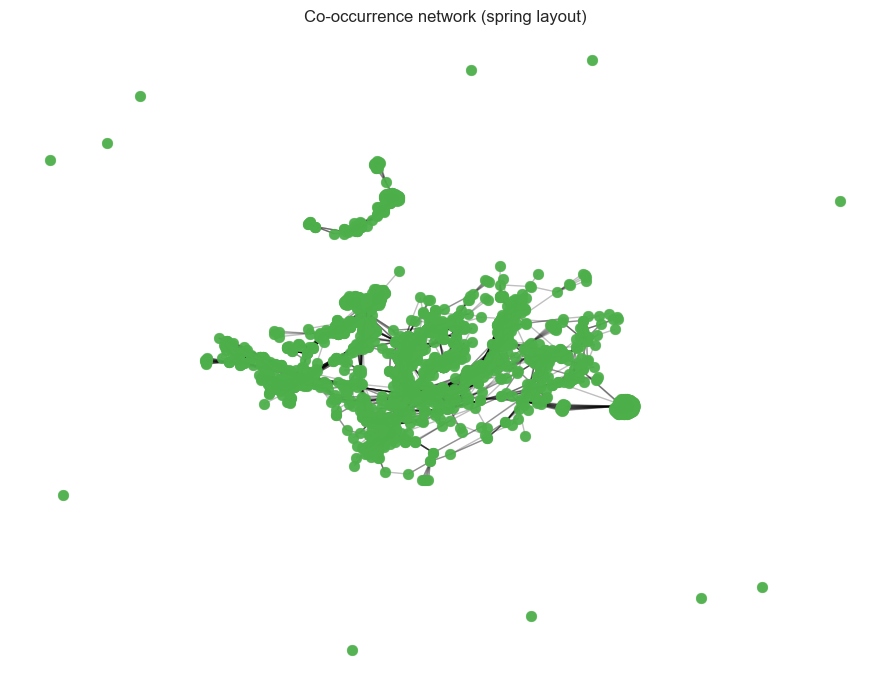

In [46]:


# Use edge weights in the spring layout so strong ties sit closer
pos = nx.spring_layout(G, weight='weight', seed=42)

plt.figure(figsize=(9, 7))
nx.draw_networkx_nodes(G, pos, node_size=60, node_color='#4daf4a', alpha=0.95)
nx.draw_networkx_edges(G, pos, alpha=0.25)
plt.title('Co-occurrence network (spring layout)')
plt.axis('off')
plt.tight_layout()
plt.show()


C:\Users\Michaelr\AppData\Local\Temp\ipykernel_1660\1751368005.py:13: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.axis('off'); plt.tight_layout(); plt.show()


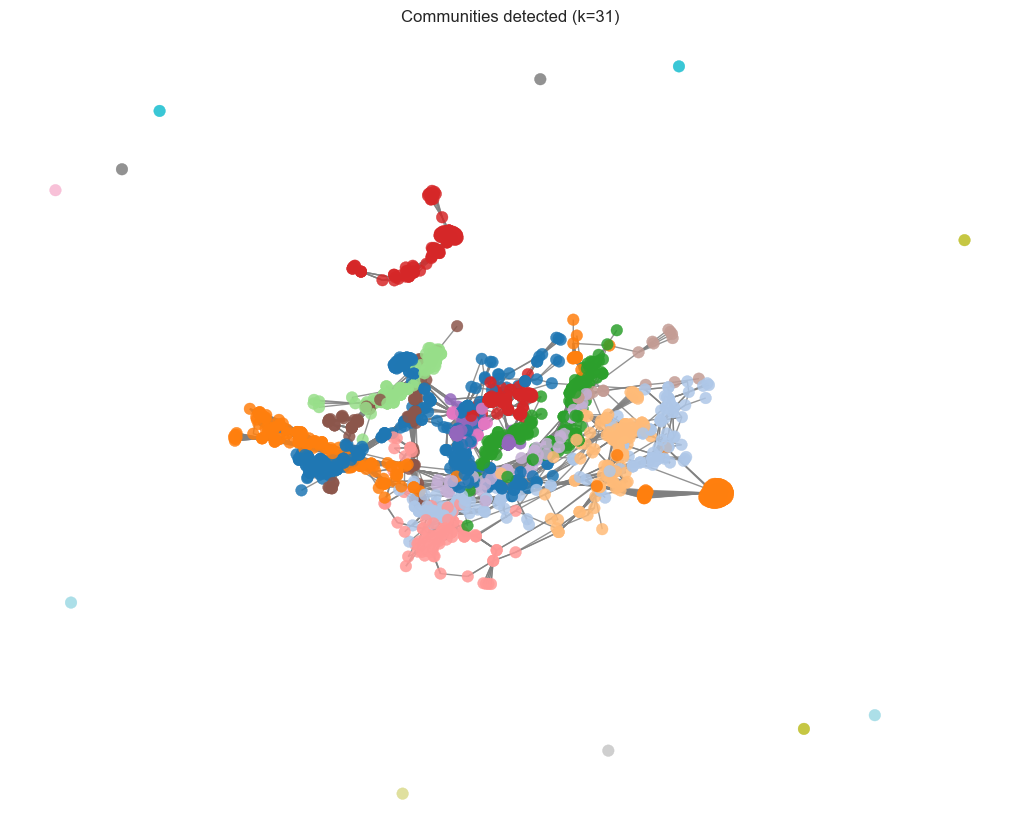

In [47]:

from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import numpy as np

communities = greedy_modularity_communities(G, weight='weight')
# Map node → community index
comm_index = {n: i for i, comm in enumerate(communities) for n in comm}
colors = [comm_index[n] for n in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=colors, cmap='tab20', node_size=70, edge_color='gray', alpha=0.85, with_labels=False)
plt.title(f'Communities detected (k={len(communities)})')
plt.axis('off'); plt.tight_layout(); plt.show()


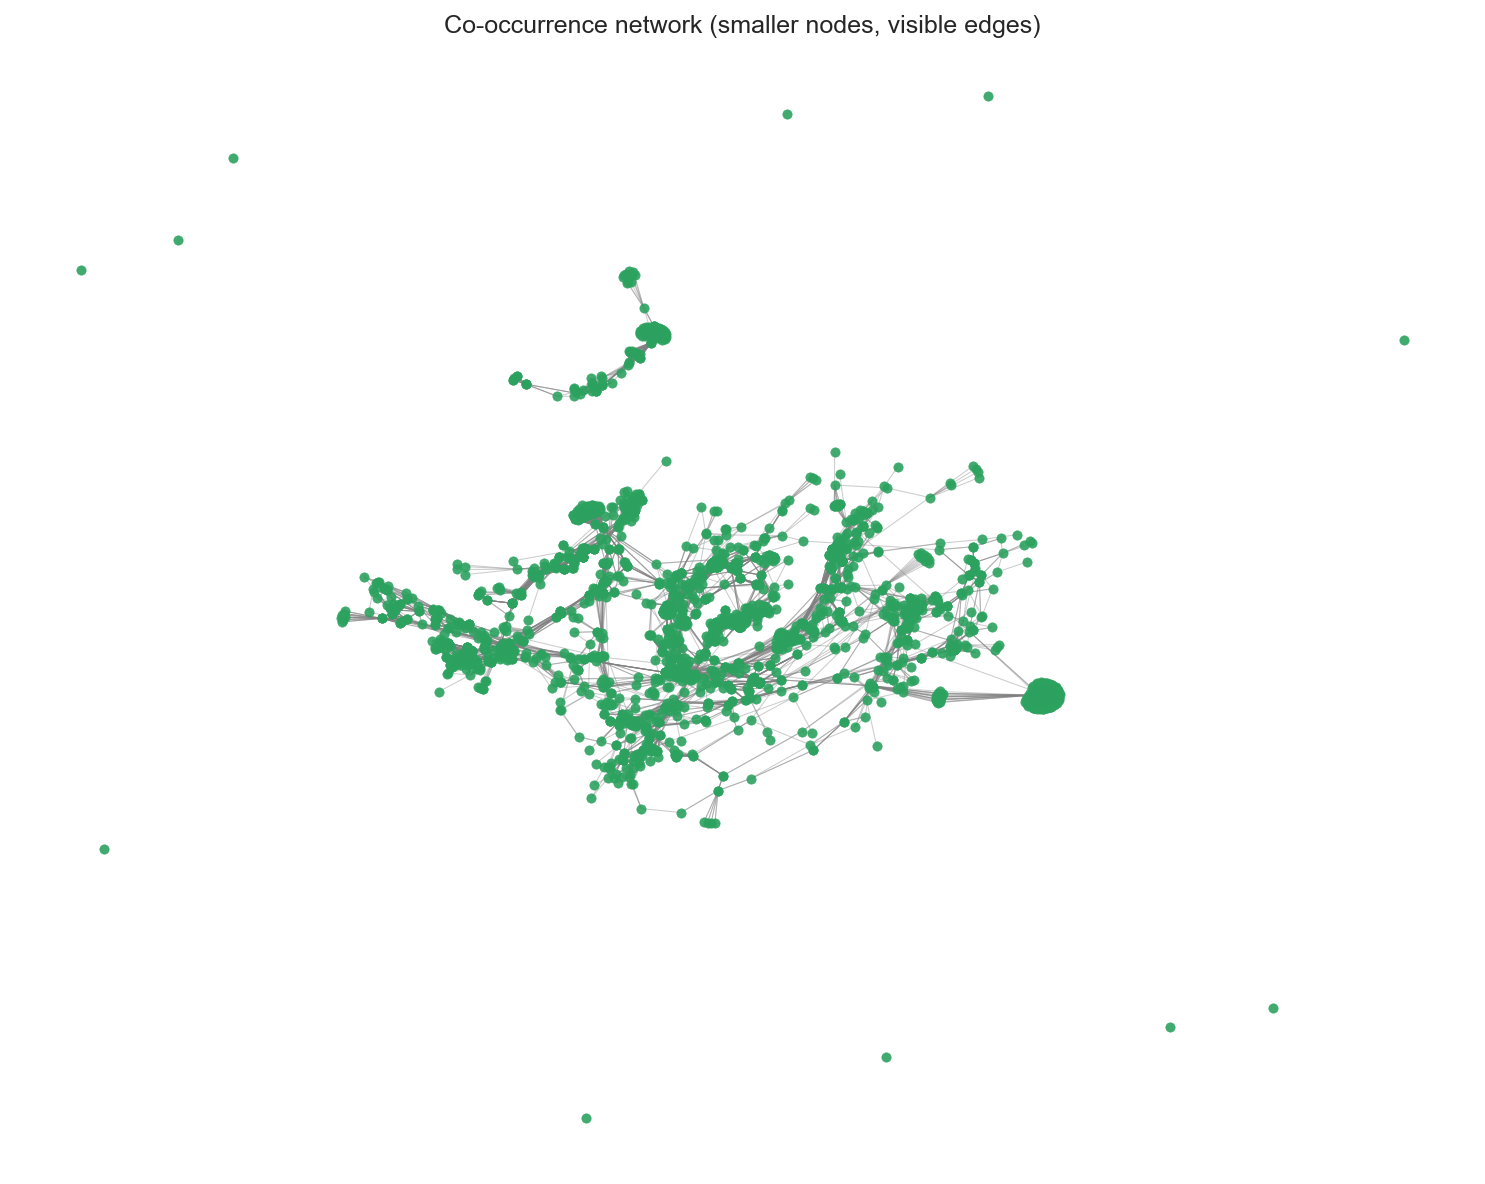

In [58]:

import networkx as nx
import matplotlib.pyplot as plt

# 1) Use a stable force layout that respects weights
pos = nx.spring_layout(G, weight='weight', seed=42)  # try 'k' parameter for spread: k=0.1 or k=0.3

# 2) Smaller nodes, softer edge lines
plt.figure(figsize=(10, 8), dpi=150)

# Draw edges first so nodes sit on top
nx.draw_networkx_edges(
    G, pos,
    edge_color='gray',       # visible neutral color
    alpha=0.4,              # not too faint
    width=0.5                # thin but visible
)

# Draw nodes
nx.draw_networkx_nodes(
    G, pos,
    node_size=20,            # much smaller dots
    node_color='#2ca25f',    # darker green
    alpha=0.9
)

# OPTIONAL: label a few top nodes only (comment out if not needed)
# top_nodes = sorted(dict(G.degree(weight='weight')), key=lambda n: G.degree(n, weight='weight'), reverse=True)[:15]
# nx.draw_networkx_labels(G, pos, labels={n: n for n in top_nodes}, font_size=7)

plt.title('Co-occurrence network (smaller nodes, visible edges)')
plt.axis('off')
plt.tight_layout()
plt.show()


In [49]:

import networkx as nx
import numpy as np

print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

isolates = list(nx.isolates(G))
print("Isolates:", len(isolates))

# Connected components
components = sorted(nx.connected_components(G), key=len, reverse=True)
print("Connected components:", len(components))
print("Largest CC size:", len(components[0]))

# Subgraph of largest connected component (LCC) for most analyses
LCC = G.subgraph(components[0]).copy()


Nodes: 2084
Edges: 11360
Isolates: 11
Connected components: 15
Largest CC size: 1750


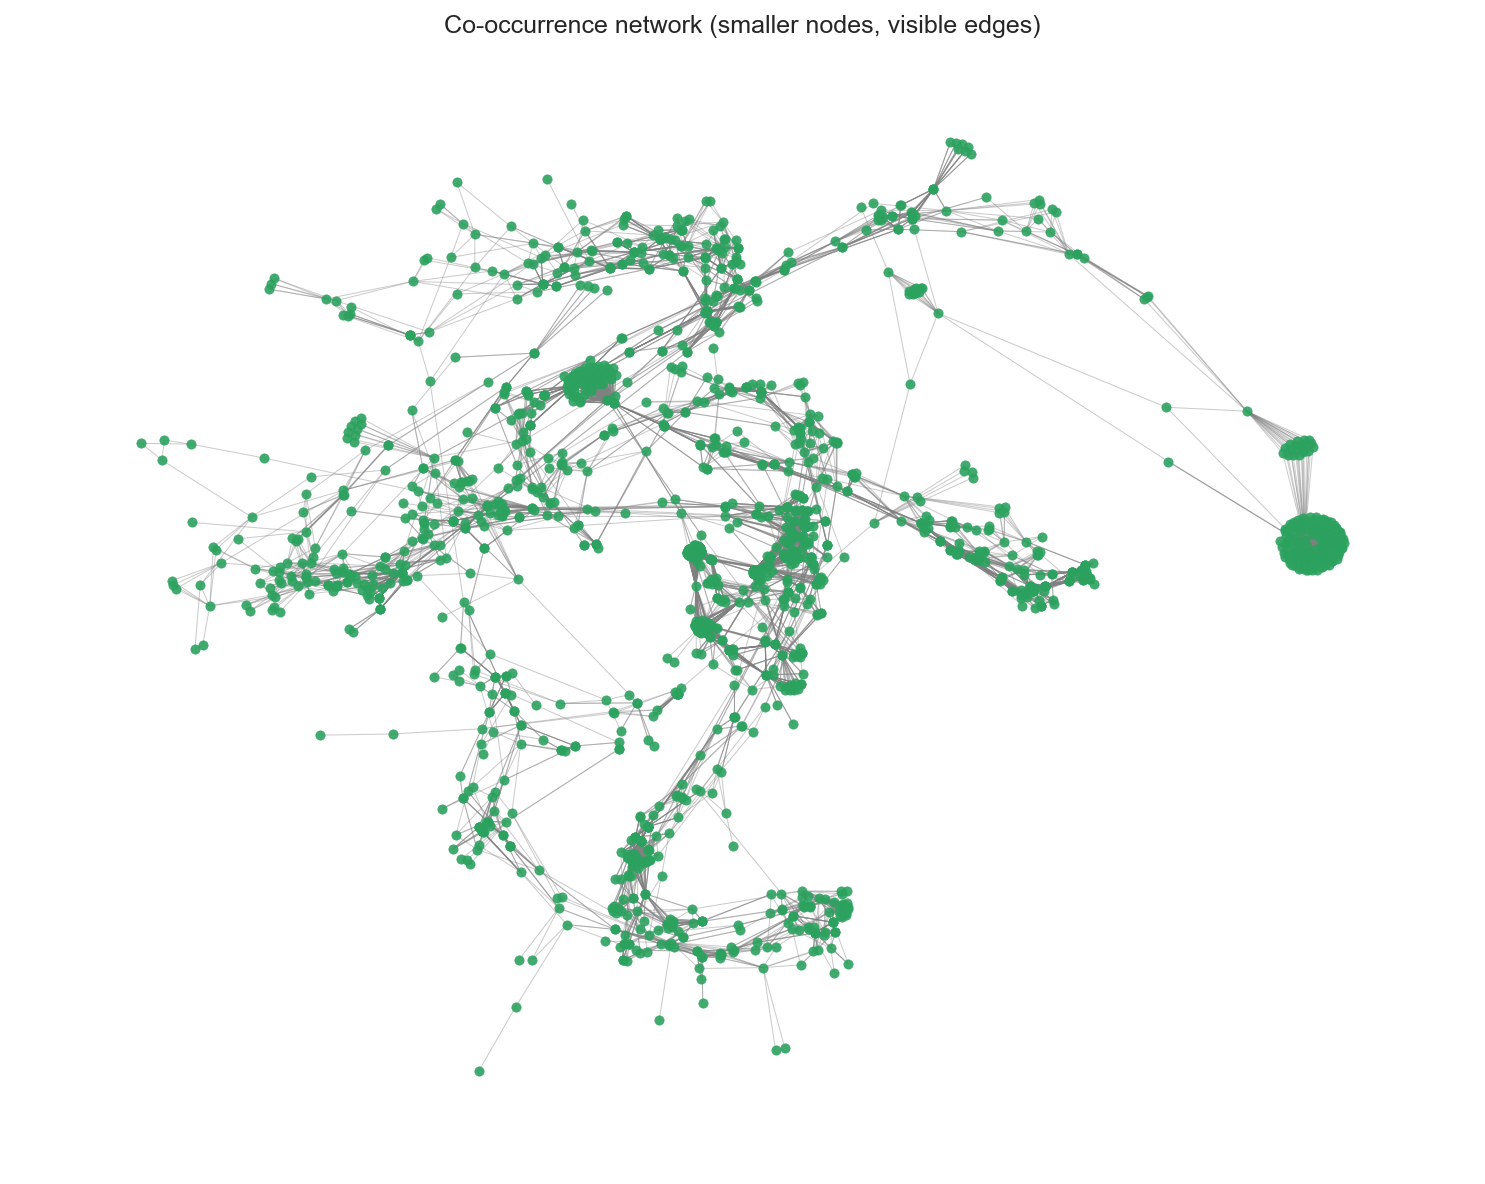

In [50]:
import networkx as nx
import matplotlib.pyplot as plt

# 1) Use a stable force layout that respects weights
pos = nx.spring_layout(LCC, weight='weight', seed=42)  # try 'k' parameter for spread: k=0.1 or k=0.3

# 2) Smaller nodes, softer edge lines
plt.figure(figsize=(10, 8), dpi=150)

# Draw edges first so nodes sit on top
nx.draw_networkx_edges(
    LCC, pos,
    edge_color='gray',       # visible neutral color
    alpha=0.4,              # not too faint
    width=0.5                # thin but visible
)

# Draw nodes
nx.draw_networkx_nodes(
    LCC, pos,
    node_size=20,            # much smaller dots
    node_color='#2ca25f',    # darker green
    alpha=0.9
)

# OPTIONAL: label a few top nodes only (comment out if not needed)
# top_nodes = sorted(dict(G.degree(weight='weight')), key=lambda n: G.degree(n, weight='weight'), reverse=True)[:15]
# nx.draw_networkx_labels(G, pos, labels={n: n for n in top_nodes}, font_size=7)

plt.title('Co-occurrence network (smaller nodes, visible edges)')
plt.axis('off')
plt.tight_layout()
plt.show()

In [52]:


weights = np.array([d['weight'] for _, _, d in G.edges(data=True)])
print(f"Edge weight stats — min:{weights.min():.4g}, median:{np.median(weights):.4g}, "
      f"mean:{weights.mean():.4g}, max:{weights.max():.4g}")


Edge weight stats — min:0.1923, median:0.4275, mean:4.946, max:504.3


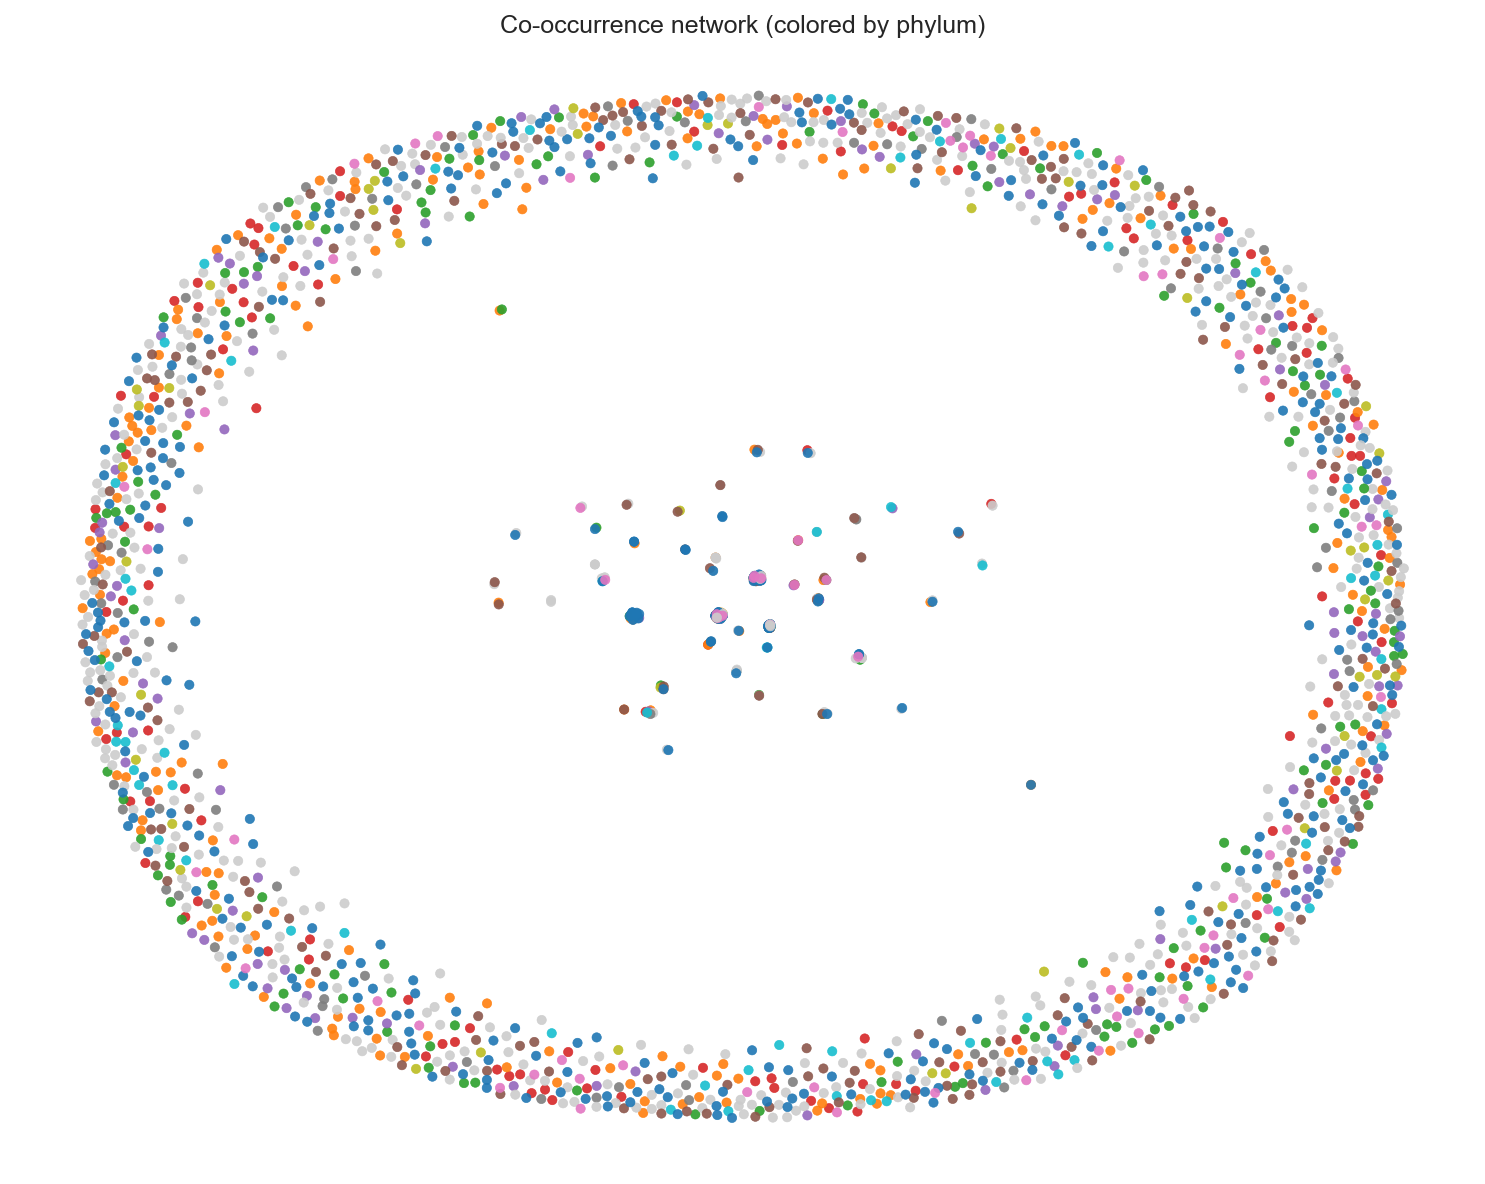

In [65]:


# -------------------------------------------------------------------------
# 0) Your phylum → color palette
# -------------------------------------------------------------------------
phyla_color_dict = {
    "Pseudomonadota": "#1f77b4",
    "Actinomycetota": "#ff7f0e",
    "Bacillota": "#2ca02c",
    "Acidobacteriota": "#d62728",
    "Bacteroidota": "#9467bd",
    "Planctomycetota": "#8c564b",
    "Verrucomicrobiota": "#e377c2",
    "Chloroflexota": "#7f7f7f",
    "Gemmatimonadota": "#bcbd22",
    "Myxococcota": "#17becf"
}
DEFAULT_COLOR = "#cccccc"

# -------------------------------------------------------------------------
# 1) Extract phylum from a GTDB/NCBI taxonomy string like:
#    k__Bacteria;p__Acidobacteriota;c__Blastocatellia;...
# -------------------------------------------------------------------------
def extract_phylum(name):
    parts = name.split(";")
    for p in parts:
        p = p.strip()
        if p.startswith("p__"):
            ph = p[3:].strip()
            return ph if ph else None
    return None

# Attach phylum attribute to nodes
node_to_phylum = {n: extract_phylum(n) for n in G.nodes()}
nx.set_node_attributes(G, node_to_phylum, "phylum")

# -------------------------------------------------------------------------
# 2) Compute the SAME layout you used before
# -------------------------------------------------------------------------
pos = nx.spring_layout(G, weight='weight', seed=42)

# -------------------------------------------------------------------------
# 3) Build node colors from the phylum attribute
# -------------------------------------------------------------------------
node_colors = []
for n in G.nodes():
    ph = G.nodes[n].get("phylum")
    node_colors.append(phyla_color_dict.get(ph, DEFAULT_COLOR))

# -------------------------------------------------------------------------
# 4) Plot EXACTLY like your original code, just with node_color=node_colors
# -------------------------------------------------------------------------
plt.figure(figsize=(10, 8), dpi=150)

nx.draw_networkx_edges(
    G, pos,
    edge_color='gray',
    alpha=0.4,
    width=0.5
)

nx.draw_networkx_nodes(
    G, pos,
    node_size=20,
    node_color=node_colors,   # ← THIS is the only change
    alpha=0.9
)

plt.title('Co-occurrence network (colored by phylum)')
plt.axis('off')
plt.tight_layout()
plt.show()
